In [1]:
from qiskit import *
import numpy as np
from qiskit.circuit.library import MCXGate
from qiskit.primitives import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
full_image = np.load('./data/images_test_100.npy')

In [3]:
test_image = full_image[1]

quantum_input = test_image.reshape(7,7,4,4)
quantum_input = np.array(quantum_input/4,dtype=int)

In [4]:
def data_in_bit(inputs):
    res = []
    for i in inputs:
        temp = []
        for j in i:
            binary = format(j,'b').zfill(4)
            binary = reverse_str(binary)
            temp.append(binary)
        res.append(temp)
    return np.array(res)
def reverse_str(str_):
    res = ''
    for i in range(len(str_)):
        res = res + str_[-i-1]
    return res

In [5]:
X_index = QuantumRegister(2,name='X_layer')
Y_index = QuantumRegister(2,name='Y_layer')
coeffs = QuantumRegister(6,name='coeffs_layer')

def make_qc_layers(quantum_input):
    qc_layers = []
    for z in range(7):
        temp_layer = []
        for m in range(7):
            binary_inputs = data_in_bit(quantum_input[z][m])
            qc = QuantumCircuit(X_index,Y_index,coeffs)

            for i in range(2):
                qc.h(X_index[i])
            for i in range(2):
                qc.h(Y_index[i])

            for i in range(4):
                for j in range(4):
                    X_idx = format(i,'b').zfill(2)
                    Y_idx = format(j,'b').zfill(2)
                    coeff = binary_inputs[i][j]
                    gate = MCXGate(4,ctrl_state=X_idx+Y_idx)
                    for index,k in enumerate(coeff):
                        if k == '1':
                            qc.append(gate,X_index[:]+Y_index[:]+[coeffs[index]])
            qc.measure_all()
            temp_layer.append(qc)
        qc_layers.append(temp_layer)
    return qc_layers
            


In [6]:
def decoder(qc_layers):
    all_result = []

    for z in range(7):
        temp_result = []
        for m in range(7):
            
            sampler = Sampler()
            qc = qc_layers[z][m]
            result = sampler.run(qc).result().quasi_dists[0]
            binary_dict = {}

            for i in result.keys():
                binary_dict[format(i,'b').zfill(10)] = result[i]
                
            decoded_result = []
            
            for i in range(4):
                temp = []
                for j in range(4):
                    X_idx = format(i,'b').zfill(2)
                    Y_idx = format(j,'b').zfill(2)
                    key = X_idx+Y_idx
                    
                    for k in binary_dict.keys():
                        if k[6:] == key:
                            temp.append(int(k[:6],2))
                decoded_result.append(temp)        
            decoded_result = np.array(decoded_result)*4
            temp_result.append(decoded_result)
        all_result.append(temp_result)
    all_result = np.array(all_result)

    final_res = all_result.reshape(28,28)
    return final_res



In [7]:
def decoder(qc_layers):
    all_result = []

    for z in range(7):
        temp_result = []
        for m in range(7):
            
            sampler = Sampler()
            qc = qc_layers[z][m]
            result = sampler.run(qc).result().quasi_dists[0]
            binary_dict = {}

            for i in result.keys():
                binary_dict[format(i,'b').zfill(10)] = result[i]
                
            decoded_result = []
            
            for i in range(4):
                temp = []
                for j in range(4):
                    X_idx = format(i,'b').zfill(2)
                    Y_idx = format(j,'b').zfill(2)
                    key = X_idx+Y_idx
                    value = []
                    prob = 0
                    query_list = []
                    for k in binary_dict.keys():
                        if k[6:] == key:
                            value.append(int(k[:6],2))
                            prob += binary_dict[k]
                            query_list.append(k)
                    res = 0
                    max_prob = 0
                    max_index = 0
                    for index in range(len(value)):
                        if binary_dict[query_list[index]]>max_prob:
                            max_prob = binary_dict[query_list[index]]
                            max_index = index
                                                        
                    temp.append(value[max_index])
                decoded_result.append(temp)        
            decoded_result = np.array(decoded_result)*4
            temp_result.append(decoded_result)
        all_result.append(temp_result)
    all_result = np.array(all_result)

    final_res = all_result.reshape(28,28)
    return final_res

# Now run on simulator and real QPU

In [8]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("6oJO91HVKgPtmTFhYbjnZxZ4NQ3lENmm")


In [9]:
print(provider.backends())
QPU = provider.get_backend("ionq_qpu.Area_1")

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


In [10]:
from qiskit.providers.jobstatus import JobStatus
import time
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.providers.fake_provider import FakeSherbrooke
from qiskit import transpile
from tqdm import tqdm
from qiskit.primitives import BackendSampler
backend = FakeSherbrooke()
sampler = BackendSampler(backend)
def decoder_QPU(qc_layers):
    all_result = []

    for z in tqdm(range(7)):
        temp_result = []
        for m in range(7):

            qc = qc_layers[z][m]
            qc = qc.decompose(reps=10)
            qc = transpile(qc)
            qc = qc_layers[z][m]
            result = sampler.run(qc).result().quasi_dists[0]
            binary_dict = {}

            for i in result.keys():
                binary_dict[format(i,'b').zfill(10)] = result[i]
                
            decoded_result = []
            for i in range(4):
                temp = []
                for j in range(4):
                    X_idx = format(i,'b').zfill(2)
                    Y_idx = format(j,'b').zfill(2)
                    key = X_idx+Y_idx
                    value = []
                    prob = 0
                    query_list = []
                    for k in binary_dict.keys():
                        if k[6:] == key:
                            value.append(int(k[:6],2))
                            prob += binary_dict[k]
                            query_list.append(k)
                    res = 0
                    for index in range(len(value)):
                        res += value[index]*binary_dict[query_list[index]]/prob                            
                    temp.append(res)
                decoded_result.append(temp)        
            decoded_result = np.array(decoded_result)*4
            temp_result.append(decoded_result)
        all_result.append(temp_result)
    all_result = np.array(all_result)

    final_res = all_result.reshape(28,28)
    return final_res

In [11]:
from qiskit.providers.jobstatus import JobStatus
import time
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.providers.fake_provider import FakeSherbrooke
from qiskit import transpile
from tqdm import tqdm
from qiskit.primitives import BackendSampler
backend = FakeSherbrooke()
sampler = BackendSampler(backend)
def decoder_QPU_max(qc_layers):
    all_result = []

    for z in tqdm(range(7)):
        temp_result = []
        for m in range(7):

            qc = qc_layers[z][m]
            qc = qc.decompose(reps=10)
            qc = transpile(qc)
            qc = qc_layers[z][m]
            result = sampler.run(qc).result().quasi_dists[0]
            binary_dict = {}

            for i in result.keys():
                binary_dict[format(i,'b').zfill(10)] = result[i]
                
            decoded_result = []
            for i in range(4):
                temp = []
                for j in range(4):
                    X_idx = format(i,'b').zfill(2)
                    Y_idx = format(j,'b').zfill(2)
                    key = X_idx+Y_idx
                    value = []
                    prob = 0
                    query_list = []
                    for k in binary_dict.keys():
                        if k[6:] == key:
                            value.append(int(k[:6],2))
                            prob += binary_dict[k]
                            query_list.append(k)
                    res = 0
                    max_prob = 0
                    max_index = 0
                    for index in range(len(value)):
                        if binary_dict[query_list[index]]>max_prob:
                            max_prob = binary_dict[query_list[index]]
                            max_index = index
                    
                    temp.append(value[max_index])
                decoded_result.append(temp)        
            decoded_result = np.array(decoded_result)*4
            temp_result.append(decoded_result)
        all_result.append(temp_result)
    all_result = np.array(all_result)

    final_res = all_result.reshape(28,28)
    return final_res

In [12]:
test_set = full_image[5:10]
qc_set = []
for i in test_set:
    quantum_input = i.reshape(7,7,4,4)
    quantum_input = np.array(quantum_input/4,dtype=int)
    qc_set.append(quantum_input)

In [13]:
## Simulator
result_set = []
for image in qc_set:
    qc_layers = make_qc_layers(image)
    result_image = decoder(qc_layers)
    result_set.append(result_image)

Simulator result


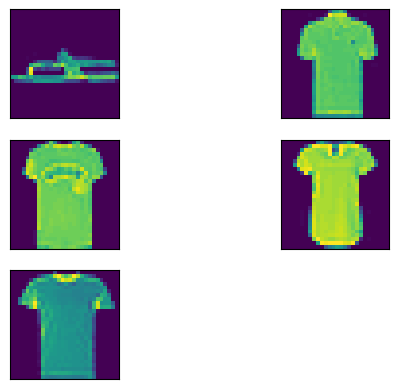

In [14]:
import glob
print('Simulator result')
fig = plt.figure() 
rows = 3
cols = 2
i = 1
for image in result_set:
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(image)
    ax.set_xticks([]), ax.set_yticks([])
    i = i+1


plt.show()


In [15]:
## Noise_model
result_set_noise = []
for image in qc_set:
    qc_layers = make_qc_layers(image)
    result_image = decoder_QPU(qc_layers)
    result_set_noise.append(result_image)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [06:30<00:00, 55.76s/it]


Simulator result


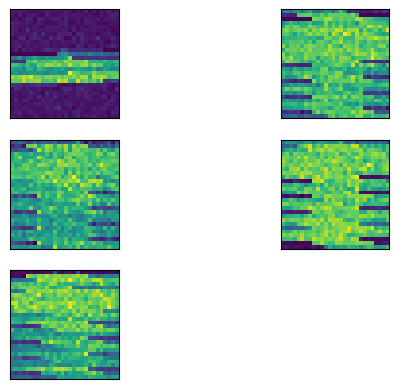

In [16]:
## Result of average pooling
print('Simulator result')
fig = plt.figure() 
rows = 3
cols = 2
i = 1
for image in result_set_noise:
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(image)
    ax.set_xticks([]), ax.set_yticks([])
    i = i+1


plt.show()

In [17]:
## Noise_model_max_pooling
result_set_noise = []
for image in qc_set:
    qc_layers = make_qc_layers(image)
    result_image = decoder_QPU_max(qc_layers)
    result_set_noise.append(result_image)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [05:45<00:00, 49.40s/it]


Simulator result


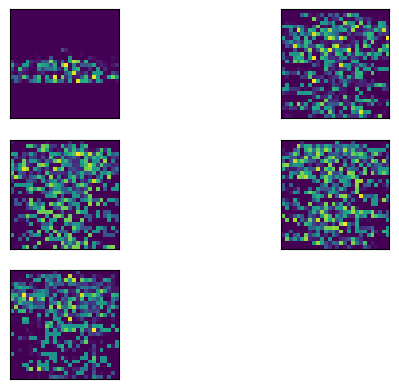

In [18]:
## Result of max pooling(little better)
print('Simulator result')
fig = plt.figure() 
rows = 3
cols = 2
i = 1
for image in result_set_noise:
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(image)
    ax.set_xticks([]), ax.set_yticks([])
    i = i+1


plt.show()